In [1]:
import numpy as np
import math
import pandas as pd
import cv2
import os
#import tqdm
#from scipy.io import loadmat

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from PIL import Image
# import pytesseract

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K

# from utils import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.layers import *

# from keras.applications import MobileNetV2
# from keras.applications import InceptionResNetV2

from keras.models import Model
from keras.models import model_from_json
from keras import regularizers

#from keras.initializers import he_normal


In [2]:
target_size = [608, 608]

target_w = 608 # target sizes of image in model input
target_h = 608 #target sizes of image in model input

class_num = 1     ## item

categories = ['bom'] # details of classes

In [3]:
# Loading output of VGG Image Annotation tool and create a dataframe

region_data = []
r_data = pd.DataFrame()

for i in range(1, 28):
    via_folder = '/Users/subrata/workstation/jupyterFiles/yolo_data_file/via_region_data_drg_test_' + str(i) + '.csv'
    region = pd.read_csv(via_folder)
    region_data.append(region)
    
r_data = pd.concat(region_data).reset_index()

r_data_master = r_data[~r_data['region_shape_attributes'].str.contains('{}')].reset_index(drop=True) # remove drgs having no bbox info
r_data_master_unique = r_data_master.drop_duplicates('#filename', keep=False).reset_index(drop=True) # remove duplicate rows
r_data_master_unique.drop(r_data_master_unique.columns[[0, 2, 3, 4, 5]], axis=1, inplace=True) # reduce unnecessary columns

num_images_in_data_master = r_data_master_unique["#filename"].nunique()
r_data_master_image_list = r_data_master_unique["#filename"].tolist()


In [4]:

print(r_data_master_unique.isnull().any())   ## check whether any Nan value in any cell
print('==============')
print(r_data_master_unique.eq(0).any())  ## check whether any '0' value in any cell


#filename                  False
region_shape_attributes    False
region_attributes          False
dtype: bool
#filename                  False
region_shape_attributes    False
region_attributes          False
dtype: bool


In [5]:
num_image_folder = []
drg_image = []

for i in range(1, 28):
    drg_folder = 'drg_test_' + str(i)
    drg_directory = '/Users/subrata/workstation/jupyterFiles/yolo_data_file/' + drg_folder
    inter_var_1 = drg_directory + '/{}'
    drg_folder = [inter_var_1.format(i) for i in os.listdir(drg_directory)]
    num_image_folder.append(len(drg_folder))
    drg_image.append(drg_folder)

print('Number of images in folders = ', num_image_folder)
num_images = len(drg_image)
print('Number of image folders = ', num_images)


Number of images in folders =  [36, 36, 36, 42, 36, 41, 35, 54, 54, 40, 106, 54, 61, 53, 98, 97, 95, 99, 12, 32, 45, 45, 45, 47, 46, 66, 58]
Number of image folders =  27


In [6]:
## drg_image above is a list of lists. We need to flatten this and create a dataframe: 

from itertools import chain

drg_image_path_df = pd.DataFrame()

k = list(chain.from_iterable(map(list, drg_image)))
drg_image = k
drg_image.sort() # Sorting the list

drg_image_path_values = pd.Series(drg_image)
drg_image_path_df.insert(loc=0, column='i_path', value = drg_image_path_values)

drg_image_path_df.tail(3)


,i_path
1466,/Users/subrata/workstation/jupyterFiles/yolo_d...
1467,/Users/subrata/workstation/jupyterFiles/yolo_d...
1468,/Users/subrata/workstation/jupyterFiles/yolo_d...


In [7]:
# remove duplicate drawings across folders and create a column for image path

drg_image_path_df['drg_no'] = drg_image_path_df['i_path'].apply(lambda x: x.split('/')[-1])
drg_image_path_df = drg_image_path_df.drop_duplicates(subset='drg_no').reset_index(drop=True)
# drg_image_path_df = drg_image_path_df.drop('drg_no', axis=1)
drg_image_path_df.tail(3)

,i_path,drg_no
1453,/Users/subrata/workstation/jupyterFiles/yolo_d...,10834-2-20-SWZ-01-11-Model-page-001.jpg
1454,/Users/subrata/workstation/jupyterFiles/yolo_d...,10834-2-20-SWZ-04-00-Model-page-001.jpg
1455,/Users/subrata/workstation/jupyterFiles/yolo_d...,10834-2-20-SWZ-04-02-Model-page-001.jpg


In [8]:
# merge two data frames on drg.no. or file name and create a combined dataframe with required columns :

merged_drg_data = pd.merge(drg_image_path_df.rename(columns={'drg_no': '#filename'}), r_data_master_unique, on='#filename')
merged_drg_data.tail(3)

,i_path,#filename,region_shape_attributes,region_attributes
1429,/Users/subrata/workstation/jupyterFiles/yolo_d...,10834-2-20-SWZ-01-11-Model-page-001.jpg,"{""name"":""rect"",""x"":1161,""y"":513,""width"":500,""h...","{""text"":""bom""}"
1430,/Users/subrata/workstation/jupyterFiles/yolo_d...,10834-2-20-SWZ-04-00-Model-page-001.jpg,"{""name"":""rect"",""x"":1051,""y"":709,""width"":608,""h...","{""text"":""bom""}"
1431,/Users/subrata/workstation/jupyterFiles/yolo_d...,10834-2-20-SWZ-04-02-Model-page-001.jpg,"{""name"":""rect"",""x"":1138,""y"":874,""width"":517,""h...","{""text"":""bom""}"


In [9]:
# Making a dataframe for Image_id, image path, x, y, width, height, class, image_width, image_height :

x = []  # co-ordinate of bbox left-top corner and NOT center of bbox as given by via
y = []  # co-ordinate of bbox left-top corner and NOT center of bbox as given by via
width = []  # of boundary box
height = []  # of boundary box
obj_class = []
i_width = []
i_height = []
img_path = []

for i in range(len(merged_drg_data)):
    
    # for x, y, width, height :
    r_size = merged_drg_data.values[i, 2][1:(len(merged_drg_data.values[i, 2])-1)]
    r_size_par = r_size.split(",")
    x.append(int("".join(filter(str.isdigit, r_size_par[1]))))
    y.append(int("".join(filter(str.isdigit, r_size_par[2]))))
    width.append(int("".join(filter(str.isdigit, r_size_par[3]))))
    height.append(int("".join(filter(str.isdigit, r_size_par[4]))))
    
    # for object class :
    r_attribs = merged_drg_data.values[i, 3][1:(len(merged_drg_data.values[i, 3])-1)]
    if r_attribs == '':
        this_class = 0
    else:
        this_class = 1
    obj_class.append(this_class)
    
    # for image width, height :
    foto_path = merged_drg_data.values[i,0]
    bgr_image = cv2.imread(foto_path)
    image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    i_ht, i_wd, _ = image.shape
    i_height.append(i_ht)
    i_width.append(i_wd)

# making the dataframe :    
x_values = pd.Series(x)
y_values = pd.Series(y)
width_values = pd.Series(width)
height_values = pd.Series(height)
class_values = pd.Series(obj_class)
i_width_values = pd.Series(i_width)
i_height_values = pd.Series(i_height)

merged_drg_data.insert(loc=2, column='x', value=x_values)
merged_drg_data.insert(loc=3, column='y', value=y_values)
merged_drg_data.insert(loc=4, column='width', value=width_values)
merged_drg_data.insert(loc=5, column='height', value=height_values)
merged_drg_data.insert(loc=6, column='obj_class', value=class_values)
merged_drg_data.insert(loc=7, column='img_wd', value=i_width_values)
merged_drg_data.insert(loc=8, column='img_ht', value=i_height_values)

merged_drg_data.drop(merged_drg_data.columns[[9, 10]], axis=1, inplace=True) # reduce unnecessary columns
merged_drg_data.rename({'#filename': 'img_id'}, axis=1, inplace=True) # changing column name

merged_drg_data.tail(3)


,i_path,img_id,x,y,width,height,obj_class,img_wd,img_ht
1429,/Users/subrata/workstation/jupyterFiles/yolo_d...,10834-2-20-SWZ-01-11-Model-page-001.jpg,1161,513,500,426,1,1754,1240
1430,/Users/subrata/workstation/jupyterFiles/yolo_d...,10834-2-20-SWZ-04-00-Model-page-001.jpg,1051,709,608,229,1,1754,1240
1431,/Users/subrata/workstation/jupyterFiles/yolo_d...,10834-2-20-SWZ-04-02-Model-page-001.jpg,1138,874,517,71,1,1754,1240


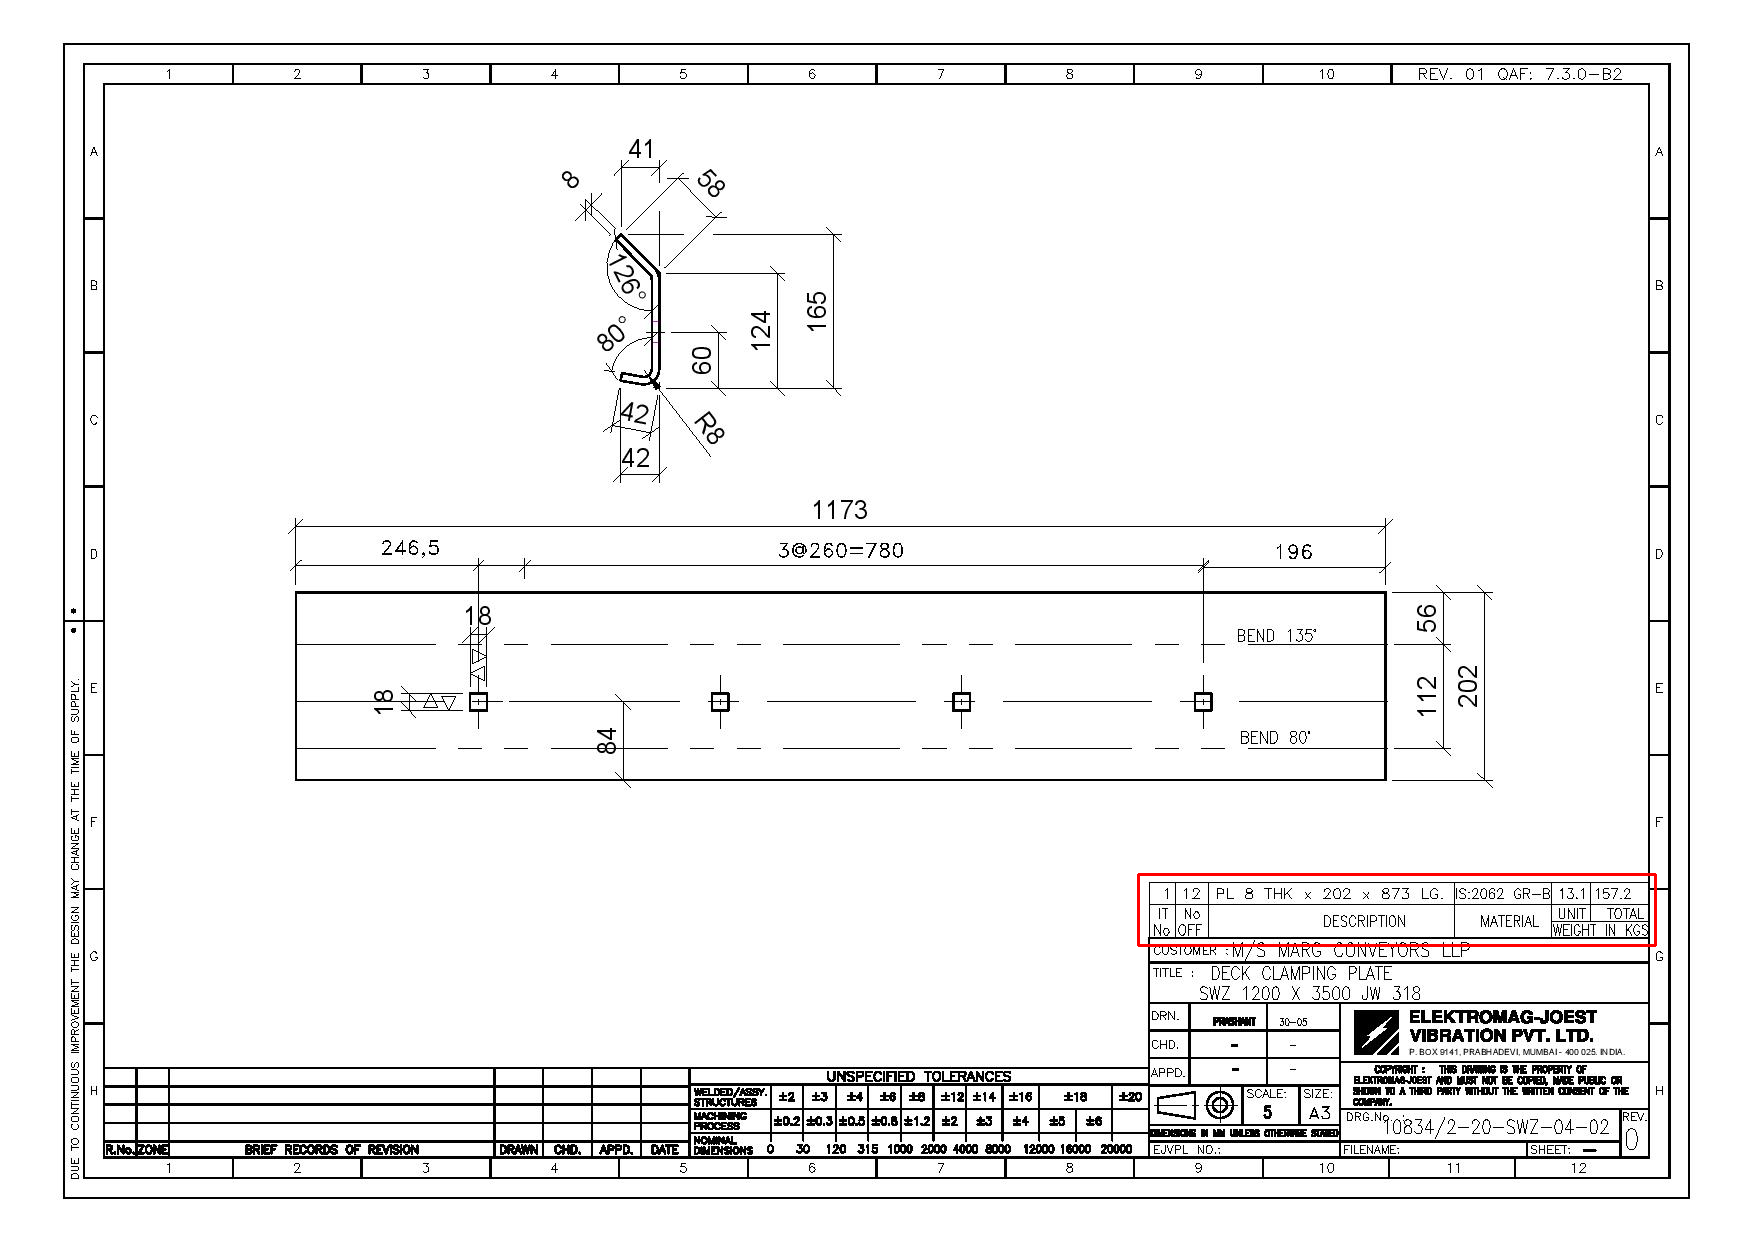

In [41]:
i = 1431

x_path = merged_drg_data['i_path'][i]
x = cv2.imread(x_path)

x_min = merged_drg_data['x'][i]
x_max = merged_drg_data['x'][i] + merged_drg_data['width'][i]

y_min = merged_drg_data['y'][i]
y_max = merged_drg_data['y'][i] + merged_drg_data['height'][i]

cv2.rectangle(x, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

x_pil = Image.fromarray(x)
display(x_pil)

In [10]:
def single_image_info(lines):
    
    ## lines will be a dataframe like, for i in range(num_images), lines = r_new_data[i*5:(i+1)*5]
    
    pic_path = lines.iat[0, 0]
    img_width = lines.iat[0, 7].astype(np.float32)
    img_height = lines.iat[0, 8].astype(np.float32)
    
    boxes = []
    labels = []
    for i in range(len(lines)):
        
        label = lines['obj_class'][i]
        x_min, y_min, x_max, y_max = float(lines.iat[i,2]), float(lines.iat[i,3]), float(lines.iat[i,2]+lines.iat[i,4]), float(lines.iat[i,3]+lines.iat[i,5])
        boxes.append([x_min, y_min, x_max, y_max])
        labels.append(label)
        
    boxes = np.asarray(boxes, np.float32)
    labels = np.asarray(labels, np.float32)
    
    return pic_path, boxes, labels, img_width, img_height  ## boxes are in format xmin, ymin, xmax, ymax


In [11]:
## Creating the complete data set :

all_image_line = []
limit_lower = 0
limit_upper = 0

for i in range(len(merged_drg_data)):

    image_line = []
    
    img = merged_drg_data['img_id'][limit_upper]
    kount = merged_drg_data['img_id'].value_counts()[img]    ## this gives no. of same images with region data of multiple categories
       
    limit_lower = limit_upper
    limit_upper = limit_lower + kount
    
    lines = merged_drg_data[limit_lower:limit_upper].reset_index(drop=True)
    """
    print('===================', i)
    print(img)
    print(limit_lower)
    print(limit_upper)
    """
    
    pic_path, boxes, labels, img_width, img_height = single_image_info(lines)
                                    
    image_line.append(pic_path)                  ## pic_path = path of the image
    image_line.append(boxes)                     ## boxes are in format xmin, ymin, xmax, ymax
    image_line.append(labels)                    ## labels are either 1 or 0
    image_line.append(img_width)
    image_line.append(img_height)
    all_image_line.append(image_line)
    
print(len(all_image_line))
print(all_image_line[1431])   ##  boxes are in format xmin, ymin, xmax, ymax

1432
['/Users/subrata/workstation/jupyterFiles/yolo_data_file/drg_test_9/10834-2-20-SWZ-04-02-Model-page-001.jpg', array([[1138.,  874., 1655.,  945.]], dtype=float32), array([1.], dtype=float32), 1754.0, 1240.0]


In [12]:
# Train and Test split

data_train_val, data_test = train_test_split(all_image_line, train_size = 0.9 , shuffle = True)
data_train, data_val = train_test_split(data_train_val, train_size = 0.80 , shuffle = True)

num_all_bbox = len(all_image_line) * len(all_image_line[0][2])
num_bb_train = len(data_train) * len(data_train[0][2])
num_bb_val = len(data_val) * len(data_val[0][2])
num_bb_test = len(data_test) * len(data_test[0][2])
print(num_all_bbox, num_bb_train, num_bb_val, num_bb_test)

1432 1030 258 144


In [51]:
data_train[0]

['/Users/subrata/workstation/jupyterFiles/yolo_data_file/drg_test_5/1174.jpg',
 array([[2215., 1372., 3150., 1818.]], dtype=float32),
 array([1.], dtype=float32),
 3509.0,
 2480.0]

In [13]:
image_index = []
image_resized = []
image_y_true = []

for i in range(len(data_train)):

    y_true = np.zeros((1,5), np.float32)
    img_resized = np.zeros((target_size[0], target_size[1]), np.float32)

    y_true[0][0] = data_train[i][2][0]
    y_true[0][1] = data_train[i][1][0][0] / data_train[i][3]
    y_true[0][2] = data_train[i][1][0][1] / data_train[i][4]
    y_true[0][3] = data_train[i][1][0][2] / data_train[i][3]
    y_true[0][4] = data_train[i][1][0][3] / data_train[i][4]

    image_y_true.append(y_true)

    bw_img = cv2.imread(data_train[i][0], cv2.IMREAD_GRAYSCALE)
    # img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(bw_img,(target_size[0], target_size[1]), interpolation=cv2.INTER_CUBIC)
    img_resized = img_resized / 255.0
    img_resized = img_resized.reshape((608,608,1))

    image_resized.append(img_resized)

X_train = np.array(image_resized).astype(np.float32)
Y_train = np.array(image_y_true).astype(np.float32)   

In [247]:
print(X_train.shape)
print(type(X_train))
print(Y_train.shape)
print(type(Y_train))

(1030, 608, 608, 1)
<class 'numpy.ndarray'>
(1030, 1, 5)
<class 'numpy.ndarray'>


In [14]:
Y_train[0:2]

array([[[1.        , 0.02863636, 0.44470587, 0.335     , 0.85588235]],

       [[1.        , 0.7330303 , 0.6521569 , 0.9257576 , 0.79333335]]],
      dtype=float32)

In [74]:
bgr_img[1200][1700][:]

array([255, 255, 255], dtype=uint8)

In [15]:
image_index = []
image_resized = []
image_y_true = []

for i in range(len(data_val)):

    y_true = np.zeros((1,5), np.float32)
    img_resized = np.zeros((target_size[0], target_size[1]), np.float32)
    
    y_true[0][0] = data_val[i][2][0]
    y_true[0][1] = data_val[i][1][0][0] / data_val[i][3]
    y_true[0][2] = data_val[i][1][0][1] / data_val[i][4]
    y_true[0][3] = data_val[i][1][0][2] / data_val[i][3]
    y_true[0][4] = data_val[i][1][0][3] / data_val[i][4]

    image_y_true.append(y_true)

    bw_img = cv2.imread(data_val[i][0], cv2.IMREAD_GRAYSCALE)
    # img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(bw_img,(target_size[0], target_size[1]), interpolation=cv2.INTER_CUBIC)
    img_resized = img_resized / 255.0
    img_resized = img_resized.reshape((608,608,1))

    image_resized.append(img_resized)

X_val = np.array(image_resized).astype(np.float32)
Y_val = np.array(image_y_true).astype(np.float32)   

In [16]:
Y_val[0:2]

array([[[0.        , 0.        , 0.        , 0.        , 0.        ]],

       [[1.        , 0.06841505, 0.7406212 , 0.54361457, 0.8487293 ]]],
      dtype=float32)

In [253]:
data_test[1]

['/Users/subrata/workstation/jupyterFiles/yolo_data_file/drg_test_11/10256-19-FUF-01-11 SH1-Model-page-001.jpg',
 array([[2188.,  289., 3220., 1926.]], dtype=float32),
 array([1.], dtype=float32),
 3300.0,
 2550.0]

In [17]:
image_index = []
image_resized = []
image_y_true = []

for i in range(len(data_test)):

    y_true = np.zeros((1,5), np.float32)
    img_resized = np.zeros((target_size[0], target_size[1]), np.float32)

    y_true[0][0] = data_test[i][2][0]
    y_true[0][1] = data_test[i][1][0][0] / data_test[i][3]
    y_true[0][2] = data_test[i][1][0][1] / data_test[i][4]
    y_true[0][3] = data_test[i][1][0][2] / data_test[i][3]
    y_true[0][4] = data_test[i][1][0][3] / data_test[i][4]

    image_y_true.append(y_true)

    bw_img = cv2.imread(data_test[i][0], cv2.IMREAD_GRAYSCALE)
    # img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(bw_img,(target_size[0], target_size[1]), interpolation=cv2.INTER_CUBIC)
    img_resized = img_resized / 255.0
    img_resized = img_resized.reshape((608,608,1))

    image_resized.append(img_resized)

X_test = np.array(image_resized).astype(np.float32)
Y_test = np.array(image_y_true).astype(np.float32)   

In [255]:
Y_test[0:2]

array([[[1.        , 0.55615735, 0.47478822, 0.9124857 , 0.73658735]],

       [[1.        , 0.6630303 , 0.11333334, 0.9757576 , 0.75529414]]],
      dtype=float32)

In [80]:
# Classification and localisation loss :
# y_true in shape (xmin, ymin, xmax, ymax, class probability)
"""
def localization_loss_2(y_true, y_pred):
    true_bbox = y_true[..., 1:]  # Updated indexing
    pred_bbox = y_pred[..., 1:]  # Updated indexing
    has_object = tf.reduce_any(y_true[..., :1] != 0, axis=-1)  # Updated axis argument
    
    loc_loss = tf.where(has_object, tf.reduce_mean(tf.square(true_bbox - pred_bbox)), 0)
    
    return loc_loss
"""
def classification_loss(y_true, y_pred):
    true_labels = y_true[..., :1]  # Updated indexing
    pred_probs = y_pred[..., :1]  # Updated indexing
    
    class_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(true_labels, pred_probs))
    
    return class_loss
"""
def localization_loss(y_true, y_pred):
    # Extract the true bounding box coordinates
    true_bbox = y_true[:, 0, 1:]
    
    # Extract the predicted bounding box coordinates
    pred_bbox = y_pred[:, 0, 1:]
    
    # Check if there is an object present
    has_object = tf.reduce_any(y_true[:, 0, :1] != 0, axis=[1, 2])
    
    # Compute the mean squared error (MSE) loss for localization only if there is an object present
    loc_loss = tf.where(has_object, tf.reduce_mean(tf.square(true_bbox - pred_bbox)), 0)
    
    return loc_loss
"""

def my_custom_loss(y_true, y_pred):
    # Compute the total loss as a combination of localization and classification losses
    # loc_loss = localization_loss_2(y_true, y_pred)
    class_loss = classification_loss(y_true, y_pred)
    total_loss = class_loss  # + loc_loss
    
    return total_loss


In [85]:
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x


In [86]:
def make_my_model_1():
    input_image = Input(shape=(608, 608, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
    x = Dropout(0.2)(x)
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
    x = Dropout(0.2)(x)
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
    x = Dropout(0.2)(x)

    """
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
    x = Dropout(0.2)(x)
    
    # Layer 16 => 36
    for i in range(2):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
    """  
      
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 36}], skip = False)
    x = _conv_block(x, [{'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 37}], skip = False)
    # x = _conv_block(x, [{'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38}], skip = False)
    x = Dropout(0.2)(x)
    """
    flat_x = Flatten()(x)
    class_output = Dense(128, activation = 'relu')(flat_x)
    class_output = Dense(1, activation = 'sigmoid')(class_output)

    reg_output = Dense(128, activation = 'relu')(flat_x)
    reg_output = Dense(4, activation = 'linear')(reg_output)

    output_data = tf.keras.layers.concatenate([class_output, reg_output], axis=-1)

    model = Model(input_image, outputs = output_data)
    return model
    """

    flat_x = Flatten()(x)
    class_output = Dense(128, activation='relu')(flat_x)
    class_output = Dense(1, activation='sigmoid')(class_output)

    #reg_output = Dense(128, activation='relu')(flat_x)
    #reg_output = Dense(4, activation='linear')(reg_output)

    #reg_output = tf.expand_dims(reg_output, axis=1)  # Add an extra dimension
    class_output = tf.expand_dims(class_output, axis=1)

    #output_data = tf.keras.layers.concatenate([class_output, reg_output], axis = -1)


    #model = Model(input_image, outputs=output_data)
    model = Model(input_image, class_output)
    return model

In [87]:
input_size = (target_w, target_h, 3)
my_model_1 = make_my_model_1()
print(my_model_1.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_0 (Conv2D)                (None, 608, 608, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bnorm_0 (BatchNormalization)   (None, 608, 608, 32  128         ['conv_0[0][0]']                 
                                )                                                             

In [89]:
epoch = 20
opt = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

my_model_1.compile(optimizer= opt, loss = my_custom_loss)
history = my_model_1.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val))

Epoch 1/20
72/72 [==============================] - 1209s 17s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/20
35/72 [=============>................] - ETA: 9:59 - loss: 0.0000e+00 

KeyboardInterrupt: 

In [116]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_1 = Sequential()
model_1.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (608, 608, 1)))
model_1.add(MaxPooling2D(pool_size=(2,2)))
model_1.add(Conv2D(64, (3,3), activation = 'relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Dropout(0.25))

model_1.add(Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(1, activation = 'sigmoid'))

print(model_1.summary())



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 606, 606, 32)      320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 303, 303, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 301, 301, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 150, 150, 64)     0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 150, 150, 64)      0         
                                                                 
 flatten_6 (Flatten)         (None, 1440000)          

In [117]:
epoch = 50
opt = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model_1.compile(loss = 'binary_crossentropy', optimizer = opt)
history = model_1.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val))

Epoch 1/50
65/65 [==============================] - 309s 5s/step - loss: 0.0110 - val_loss: 2.0753e-12
Epoch 2/50
65/65 [==============================] - 329s 5s/step - loss: 1.5615e-09 - val_loss: 1.9850e-12
Epoch 3/50
65/65 [==============================] - 402s 6s/step - loss: 8.7905e-09 - val_loss: 1.9800e-12
Epoch 4/50
65/65 [==============================] - 452s 7s/step - loss: 4.3419e-09 - val_loss: 1.9252e-12
Epoch 5/50
65/65 [==============================] - 424s 7s/step - loss: 5.6881e-09 - val_loss: 1.9094e-12
Epoch 6/50
65/65 [==============================] - 413s 6s/step - loss: 1.0016e-08 - val_loss: 1.7563e-12
Epoch 7/50
65/65 [==============================] - 433s 7s/step - loss: 4.8110e-09 - val_loss: 1.5880e-12
Epoch 8/50
65/65 [==============================] - 413s 6s/step - loss: 1.2557e-09 - val_loss: 1.5391e-12
Epoch 9/50
65/65 [==============================] - 409s 6s/step - loss: 1.3878e-08 - val_loss: 1.0701e-12
Epoch 10/50
65/65 [======================

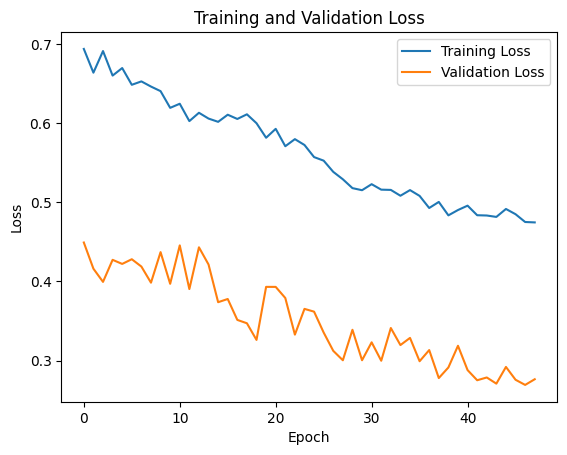

In [22]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [133]:
print(X_val.shape)
print(type(X_test))
print(Y_val.shape)
print(type(Y_test))

(258, 608, 608, 1)
<class 'numpy.ndarray'>
(258, 1, 1)
<class 'numpy.ndarray'>


In [134]:
loss, accuracy = model_1.evaluate(X_test[0:1], Y_test[0:1])
print(f"Test Loss: {loss:.2f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")


1/1 [==============================] - 0s 296ms/step - loss: 8.3845e-14


TypeError: cannot unpack non-iterable float object

In [132]:
X_test[0].shape

(608, 608, 1)

In [135]:
test_loss = model_1.evaluate(X_test, Y_test)
print(f'Test loss: {test_loss}')


5/5 [==============================] - 5s 809ms/step - loss: 1.2680e-13
Test loss: 1.267994905037803e-13


In [138]:
predictions = model_1.predict(X_test)
pred_labels = (predictions > 0.9).astype(int)
accuracy = np.mean(pred_labels == Y_test)
print(f'Test accuracy: {accuracy*100:.2f}%')


5/5 [==============================] - 5s 866ms/step
Test accuracy: 100.00%


In [23]:
input_image = Input(shape=(608, 608, 1))
x = input_image

x = Conv2D(32, (3, 3), activation = 'relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(64, (3,3), activation = 'relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
y = Dense(1, activation = 'sigmoid')(x)
z = Dense(4, activation = 'linear')(x)

y_z = concatenate([y,z])
final = Reshape((1,5))(y_z)

# model_1.add(Dense(64, activation = 'relu'))
# model_1.add(Dense(4))

model_4 = Model(input_image, final)
print(model_4.summary())


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 608, 608, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 606, 606, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 303, 303, 32  0          ['conv2d_2[0][0]']               
                                )                                                           

In [19]:
import tensorflow as tf

def combined_loss(y_true, y_pred):

    # Binary cross-entropy loss for classification
    cls_loss = K.binary_crossentropy(y_true[:,:,0], y_pred[:,:,0])
    
    # Mean squared error loss for object localization
    # loc_loss = K.mean(K.square(y_true[:,1:] - y_pred[:,1:]))
    loc_loss = tf.keras.losses.mean_squared_error(y_true[:,:,1:], y_pred[:,:,1:])
    
    # Combine losses with some weightage, depending on the task at hand
    total_loss = loc_loss + cls_loss
    
    return total_loss



In [273]:
print(Y_train[0:1])
print(Y_train[2:3])

[[[1.         0.64851767 0.5897539  0.945553   0.7624042 ]]]
[[[1.         0.60636365 0.67490196 0.9175758  0.7219608 ]]]


In [280]:
Y_train[0,0,1:]

array([0.64851767, 0.5897539 , 0.945553  , 0.7624042 ], dtype=float32)

In [288]:
aaa = Y_train[0:1]
bbb = Y_train[2:3]

my_loss = combined_loss(aaa,bbb)
my_loss

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00286139]], dtype=float32)>

In [286]:
aaa = Y_train[0:1]
bbb = Y_train[2:3]

my_loss = combined_loss(aaa,bbb)
my_loss

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.], dtype=float32)>

In [20]:
epoch = 2
opt = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model_4.compile(loss = combined_loss, optimizer = opt)
history = model_4.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val))

Epoch 1/2


2023-05-27 23:11:54.191517: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


65/65 [==============================] - 263s 4s/step - loss: 0.8483 - val_loss: 0.4753
Epoch 2/2
65/65 [==============================] - 273s 4s/step - loss: 0.6934 - val_loss: 0.6888


In [24]:
epoch = 100
opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model_4.compile(loss = combined_loss, optimizer = opt)
history = model_4.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val))

Epoch 1/100
65/65 [==============================] - 262s 4s/step - loss: 15.0805 - val_loss: 1.1606
Epoch 2/100
65/65 [==============================] - 263s 4s/step - loss: 1.1417 - val_loss: 1.1557
Epoch 3/100
65/65 [==============================] - 270s 4s/step - loss: 1.1368 - val_loss: 1.1503
Epoch 4/100
65/65 [==============================] - 276s 4s/step - loss: 1.1315 - val_loss: 1.1445
Epoch 5/100
65/65 [==============================] - 300s 5s/step - loss: 1.1258 - val_loss: 1.1383
Epoch 6/100
65/65 [==============================] - 311s 5s/step - loss: 1.1199 - val_loss: 1.1319
Epoch 7/100
65/65 [==============================] - 300s 5s/step - loss: 1.1137 - val_loss: 1.1253
Epoch 8/100
65/65 [==============================] - 303s 5s/step - loss: 1.1074 - val_loss: 1.1185
Epoch 9/100
65/65 [==============================] - 289s 4s/step - loss: 1.1009 - val_loss: 1.1115
Epoch 10/100
65/65 [==============================] - 289s 4s/step - loss: 1.0943 - val_loss: 1.104

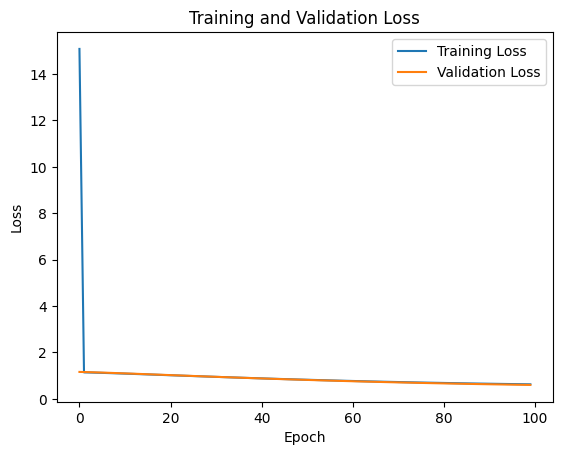

In [27]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
predictions = model_4.predict(X_test)
# pred_labels = (predictions > 0.9).astype(int)
# accuracy = np.mean(pred_labels == Y_test)
accuracy = np.mean(predictions == Y_test)
print(f'Test accuracy: {accuracy*100:.2f}%')


5/5 [==============================] - 4s 677ms/step
Test accuracy: 0.00%


In [31]:
print(X_test.shape)
print(Y_test.shape)

(144, 608, 608, 1)
(144, 1, 5)


In [35]:
pred_x = model_4(X_test)

In [36]:
pred_x.shape

TensorShape([144, 1, 5])

In [59]:
pred_x[140]

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[0.64338034, 0.40059486, 0.44930387, 0.47326204, 0.48996696]],
      dtype=float32)>

In [58]:
if np.array_equal(X_test[0], X_test[140]):
    print("identical")
else:
    print("not identical")

not identical


In [55]:
pred_x[0]

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[0.64338034, 0.40059486, 0.44930387, 0.47326204, 0.48996696]],
      dtype=float32)>

In [60]:
arr = X_test[0]
num_zeros = np.count_nonzero(arr == 0)     # Count the number of zeros in arr
num_ones = np.count_nonzero(arr == 1)      # Count the number of ones in arr
num_other = np.size(arr) - num_zeros - num_ones   # Count the remaining elements that are neither 0 nor 1

print("Number of zeros:", num_zeros)
print("Number of ones:", num_ones)
print("Number of other values:", num_other)


Number of zeros: 14550
Number of ones: 294843
Number of other values: 60271


In [61]:
arr = X_test[1]

# Assuming arr is already defined with shape (608, 608, 1)
num_zeros = np.count_nonzero(arr == 0)     # Count the number of zeros in arr
num_ones = np.count_nonzero(arr == 1)      # Count the number of ones in arr
num_other = np.size(arr) - num_zeros - num_ones   # Count the remaining elements that are neither 0 nor 1

print("Number of zeros:", num_zeros)
print("Number of ones:", num_ones)
print("Number of other values:", num_other)


Number of zeros: 8380
Number of ones: 337636
Number of other values: 23648
